# Object Detection

## Data

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
from torchvision.transforms import *
from PIL import Image

import pathlib
import xml.etree.ElementTree as ET

np.random.seed(37)
torch.manual_seed(37)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

class ShapeDataset(Dataset):

    def __init__(self, root_dir, annot_dir='annots', image_dir='images', 
                 transform=transforms.Compose([ToTensor()])):
        self.annot_dir = f'{root_dir}/{annot_dir}'
        self.image_dir = f'{root_dir}/{image_dir}'
        self.transform = transform
        self.__init()
        
    def num_classes(self):
        return len(self.class2index)
        
    def __get_annot_files(self):
        def clean_up(path):
            import os
            from shutil import rmtree

            ipynb_checkpoints = f'{path}/.ipynb_checkpoints'
            if os.path.exists(ipynb_checkpoints):
                rmtree(ipynb_checkpoints)
        clean_up(self.annot_dir)
        return [f for f in pathlib.Path(self.annot_dir).glob('**/*.xml')]
        
    def __get_classes(self):
        xml_files = self.__get_annot_files()
        names = set()
        for xml_file in xml_files:
            tree = ET.parse(xml_file) 
            root = tree.getroot()

            for item in root.findall('./object'):
                name = item.find('name').text
                if name not in names:
                    names.add(name)
        names = {name: i for i, name in enumerate(sorted(list(names)))}
        return names
    
    def __get_image_annotations(self, annot_path):
        root = ET.parse(annot_path).getroot()
        d = {}

        # file names
        d['annot_path'] = annot_path
        d['image_path'] = f"{self.image_dir}/{root.find('filename').text}"

        # size
        size = root.find('./size')
        d['size'] = {
                'width': int(size.find('width').text),
                'height': int(size.find('height').text),
                'depth': int(size.find('depth').text)
            }

        # objects
        d['objects'] = []
        for obj in root.findall('./object'):
            o = {}
            o['name'] = obj.find('name').text

            b = obj.find('bndbox')
            o['xmin'] = int(b.find('xmin').text)
            o['ymin'] = int(b.find('ymin').text)
            o['xmax'] = int(b.find('xmax').text)
            o['ymax'] = int(b.find('ymax').text)

            d['objects'].append(o)
        return d

    def __init(self):
        self.class2index = self.__get_classes()
        
        annot_paths = [f'{str(f)}' for f in self.__get_annot_files()]
        self.annotations = [self.__get_image_annotations(p) for p in annot_paths]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        def get_boxes(annot):
            boxes = [[obj[f] for f in ['xmin', 'ymin', 'xmax', 'ymax']] for obj in annot['objects']]
            return torch.as_tensor(boxes, dtype=torch.float)
        
        def get_labels(annot):
            labels = [self.class2index[obj['name']] for obj in annot['objects']]
            return torch.as_tensor(labels, dtype=torch.int64)
        
        def get_areas(annot):
            areas = [(obj['xmax'] - obj['xmin']) * (obj['ymax'] - obj['ymin']) for obj in annot['objects']]
            return torch.as_tensor(areas, dtype=torch.int64)
        
        def get_iscrowds(annot):
            return torch.zeros((len(annot['objects']),), dtype=torch.uint8)
        
        annot = self.annotations[idx]
        
        image_path = annot['image_path']
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        target = {}
        target['boxes'] = get_boxes(annot)
        target['labels'] = get_labels(annot)
        target['image_id'] = torch.as_tensor([idx], dtype=torch.int64)
        target['area'] = get_areas(annot)
        target['iscrowd'] = get_iscrowds(annot)

        return image, target

dataset = ShapeDataset('./output/iaia-polygons')
indices = torch.randperm(len(dataset)).tolist()

dataset_train = Subset(dataset, indices[0:800])
dataset_test = Subset(dataset, indices[800:1000])

dataloader_train = DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
dataloader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

## Model

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = get_device()

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = dataset.num_classes()
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

## Optimizer and scheduler

In [4]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## Helper code

In [5]:
%%sh
if [ ! -d "output/vision" ]; then
    git clone https://github.com/pytorch/vision.git output/vision
else
    echo "output/vision already cloned"
fi

cp output/vision/references/detection/utils.py .
cp output/vision/references/detection/transforms.py .
cp output/vision/references/detection/coco_eval.py .
cp output/vision/references/detection/engine.py .
cp output/vision/references/detection/coco_utils.py .

output/vision already cloned


## Training and testing

In [6]:
from engine import train_one_epoch, evaluate
import utils

num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, dataloader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/500]  eta: 0:06:42  lr: 0.000015  loss: 2.2455 (2.2455)  loss_classifier: 1.6276 (1.6276)  loss_box_reg: 0.3966 (0.3966)  loss_objectness: 0.1743 (0.1743)  loss_rpn_box_reg: 0.0469 (0.0469)  time: 0.8047  data: 0.2026  max mem: 1425
Epoch: [0]  [100/500]  eta: 0:01:29  lr: 0.001016  loss: 0.5915 (1.0514)  loss_classifier: 0.3690 (0.6415)  loss_box_reg: 0.2081 (0.3743)  loss_objectness: 0.0001 (0.0153)  loss_rpn_box_reg: 0.0148 (0.0203)  time: 0.2184  data: 0.0036  max mem: 1691
Epoch: [0]  [200/500]  eta: 0:01:06  lr: 0.002017  loss: 0.0921 (0.6134)  loss_classifier: 0.0525 (0.3667)  loss_box_reg: 0.0295 (0.2214)  loss_objectness: 0.0000 (0.0080)  loss_rpn_box_reg: 0.0101 (0.0173)  time: 0.2185  data: 0.0035  max mem: 1691
Epoch: [0]  [300/500]  eta: 0:00:44  lr: 0.003018  loss: 0.0811 (0.4349)  loss_classifier: 0.0338 (0.2571)  loss_box_reg: 0.0314 (0.1570)  loss_objectness: 0.0002 (0.0054)  loss_rpn_box_reg: 0.0095 (0.0155)  time: 0.2187  data: 0.0036  max mem: 1691


## Predictions

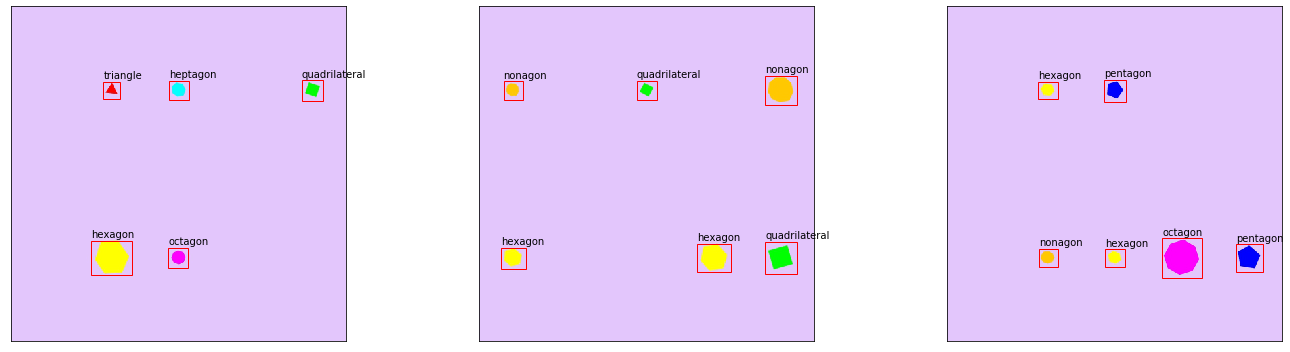

In [85]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches

def get_prediction(dataset, idx, model):
    img, _ = dataset[idx]
    
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    
    return img, prediction

def get_rects(boxes):
    rect = lambda x, y, w, h: patches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor='r', facecolor='none')
    
    return [rect(box[0], box[1], box[2], box[3]) for box in boxes]

def get_clazzes(labels, boxes, index2class):
    return [{'x': box[0].item(), 'y': box[1].item() - 5.0, 's': index2class[label.item()], 'fontsize': 10}
            for label, box in zip(labels, boxes)]

def show_prediction(img, index2class, fig, ax):
    pil_image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    
    ax.imshow(pil_image)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    for rect in get_rects(prediction[0]['boxes']):
        ax.add_patch(rect)

    
    for label in get_clazzes(prediction[0]['labels'], prediction[0]['boxes'], index2class):
        ax.text(**label)

predictions = [get_prediction(dataset_train, i, model) for i in range(3)]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
index2class = {i: c for c, i in dataset.class2index.items()}

for (img, prediction), a in zip(predictions, ax):
    show_prediction(img, index2class, fig, a)
    
plt.tight_layout()